# BGP Normal Traffic Generation using GAN - CPU Optimized Version

## Key Optimizations for CPU:
- Reduced epochs (50 instead of 200)
- Smaller hidden dimensions (64 instead of 128)
- Fewer layers (2 instead of 3)
- Option to train only ONE model
- Early stopping
- Smaller batch size for better CPU utilization

**Estimated training time on CPU: 30-60 minutes (single model)**

---

## Part 1: Environment Setup

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
from scipy import stats
import json
import os
from datetime import datetime
import time

warnings.filterwarnings('ignore')

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cpu')  # Force CPU
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.4.1+cu121


## Part 2: CPU-Optimized Configuration

### ⚠️ IMPORTANT: Choose which model to train

In [16]:
# ============================================================================
# CPU-OPTIMIZED CONFIGURATION
# ============================================================================

CONFIG = {
    # Data paths
    'data_path': '/home/smotaali/BGP_Traffic_Generation/results/rrc04_20251116_exctracted_1s_FIXED.csv',
    'output_dir': '/home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/',
    
    # ========================================
    # MODEL SELECTION - Choose ONE to train
    # ========================================
    # Options: 'TimeGAN', 'LSTM-GAN', 'DoppelGANger', 'all'
    # Recommendation: Start with 'LSTM-GAN' (fastest) or 'TimeGAN' (best quality)
    'model_to_train': 'all',
    
    # Feature configuration
    'selected_features' : [
        'announcements', 'withdrawals', 'nlri_ann', 'dups',
        'origin_0', 'origin_2', 'origin_changes',
        'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
        'as_path_max', 'unique_as_path_max',
        'edit_distance_avg', 'edit_distance_max',
        'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
        'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
        'edit_distance_dict_6',
        'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
        'number_rare_ases', 'rare_ases_avg',
        'nadas', 'flaps'
    ],
    
    # Columns to drop
    'drop_columns': ['label', 'window_start', 'window_end'],
    
    # Sequence parameters
    'sequence_length': 20,  # Reduced from 30
    'stride': 5,  # Increased stride to reduce samples
    
    # Train/test split
    'test_size': 0.2,
    'validation_size': 0.1,
    
    # ========================================
    # CPU-OPTIMIZED TRAINING PARAMETERS
    # ========================================
    'batch_size': 32,  # Smaller batch for CPU
    'epochs': 50,  # Reduced from 200
    'learning_rate': 0.001,  # Slightly higher for faster convergence
    'beta1': 0.5,
    'beta2': 0.999,
    
    # ========================================
    # REDUCED MODEL ARCHITECTURE
    # ========================================
    'latent_dim': 16,  # Reduced from 32
    'hidden_dim': 64,  # Reduced from 128
    'num_layers': 2,  # Reduced from 3
    
    # Early stopping
    'early_stopping': True,
    'patience': 10,
    
    # Evaluation
    'n_synthetic_samples': 500,  # Reduced from 1000
    
    # Limit training data (set to None to use all)
    'max_train_sequences': 5000,  # Limit sequences for faster training
}

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("="*60)
print("CPU-OPTIMIZED CONFIGURATION")
print("="*60)
print(f"Model to train: {CONFIG['model_to_train']}")
print(f"Epochs: {CONFIG['epochs']}")
print(f"Hidden dim: {CONFIG['hidden_dim']}")
print(f"Num layers: {CONFIG['num_layers']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Sequence length: {CONFIG['sequence_length']}")
print(f"Max training sequences: {CONFIG['max_train_sequences']}")
print(f"\nEstimated training time: 20-40 minutes for single model")

CPU-OPTIMIZED CONFIGURATION
Model to train: all
Epochs: 50
Hidden dim: 64
Num layers: 2
Batch size: 32
Sequence length: 20
Max training sequences: 5000

Estimated training time: 20-40 minutes for single model


## Part 3: Data Loading and Preprocessing

In [17]:
# Load and preprocess data
print("Loading data...")
start_time = time.time()

df = pd.read_csv(CONFIG['data_path'])
print(f"Loaded in {time.time()-start_time:.2f}s")
print(f"Original shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Loading data...
Loaded in 0.41s
Original shape: (86387, 30)
Label distribution:
label
normal    86387
Name: count, dtype: int64


In [18]:
# Filter to normal traffic
df_normal = df[df['label'] == 'normal'].copy()
print(f"\nNormal traffic: {len(df_normal)} rows ({100*len(df_normal)/len(df):.1f}%)")

# Select features
available_features = [f for f in CONFIG['selected_features'] if f in df_normal.columns]
missing_features = [f for f in CONFIG['selected_features'] if f not in df_normal.columns]

if missing_features:
    print(f"Warning: Missing features: {missing_features}")

print(f"Using {len(available_features)} features")

df_features = df_normal[available_features].fillna(0)
print(f"Feature data shape: {df_features.shape}")


Normal traffic: 86387 rows (100.0%)
Using 27 features
Feature data shape: (86387, 27)


In [19]:
# Normalize
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df_features.values)
print(f"Normalized data: mean={data_normalized.mean():.4f}, std={data_normalized.std():.4f}")

Normalized data: mean=0.0000, std=0.9027


In [20]:
# Create sequences with larger stride for fewer samples
def create_sequences(data, seq_length, stride=1):
    sequences = []
    for i in range(0, len(data) - seq_length + 1, stride):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

print(f"\nBuilding sequences (T={CONFIG['sequence_length']}, stride={CONFIG['stride']})...")
sequences = create_sequences(data_normalized, CONFIG['sequence_length'], CONFIG['stride'])
print(f"Total sequences: {sequences.shape}")

# Limit sequences for faster training
if CONFIG['max_train_sequences'] and len(sequences) > CONFIG['max_train_sequences']:
    indices = np.random.choice(len(sequences), CONFIG['max_train_sequences'], replace=False)
    sequences = sequences[indices]
    print(f"Limited to {len(sequences)} sequences for faster training")


Building sequences (T=20, stride=5)...


Total sequences: (17274, 20, 27)
Limited to 5000 sequences for faster training


In [21]:
# Train/Test/Val Split
X_train_val, X_test = train_test_split(sequences, test_size=CONFIG['test_size'], random_state=SEED)
X_train, X_val = train_test_split(X_train_val, test_size=CONFIG['validation_size'], random_state=SEED)

print(f"\nData splits:")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Create DataLoaders
train_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_train)), 
    batch_size=CONFIG['batch_size'], 
    shuffle=True, 
    drop_last=True
)
val_loader = DataLoader(
    TensorDataset(torch.FloatTensor(X_val)), 
    batch_size=CONFIG['batch_size']
)

print(f"\nTrain batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Data splits:
  Training: (3600, 20, 27)
  Validation: (400, 20, 27)
  Test: (1000, 20, 27)

Train batches: 112, Val batches: 13


## Part 4: Simplified GAN Models (CPU-Optimized)

In [22]:
# ============================================================================
# LSTM-GAN (Fastest on CPU)
# ============================================================================

class LSTMGAN_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )
        
    def forward(self, z):
        lstm_out, _ = self.lstm(z)
        return self.fc(lstm_out)


class LSTMGAN_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


class LSTMGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, seq_len):
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        self.generator = LSTMGAN_Generator(latent_dim, hidden_dim, input_dim, num_layers, seq_len)
        self.discriminator = LSTMGAN_Discriminator(input_dim, hidden_dim, num_layers)
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def train(self, train_loader, val_loader, epochs, lr=0.001, early_stopping=True, patience=10):
        opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        
        history = {'g_loss': [], 'd_loss': [], 'val_loss': []}
        best_val_loss = float('inf')
        patience_counter = 0
        
        print(f"\nStarting LSTM-GAN training ({epochs} epochs)...")
        start_time = time.time()
        
        for epoch in range(epochs):
            epoch_start = time.time()
            g_losses, d_losses = [], []
            
            self.generator.train()
            self.discriminator.train()
            
            for batch in train_loader:
                real_data = batch[0]
                batch_size = real_data.size(0)
                
                real_labels = torch.ones(batch_size, 1)
                fake_labels = torch.zeros(batch_size, 1)
                
                # Train Discriminator
                opt_d.zero_grad()
                real_output = self.discriminator(real_data)
                d_loss_real = self.bce_loss(real_output, real_labels)
                
                z = torch.randn(batch_size, self.seq_len, self.latent_dim)
                fake_data = self.generator(z)
                fake_output = self.discriminator(fake_data.detach())
                d_loss_fake = self.bce_loss(fake_output, fake_labels)
                
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                opt_d.step()
                
                # Train Generator
                opt_g.zero_grad()
                z = torch.randn(batch_size, self.seq_len, self.latent_dim)
                fake_data = self.generator(z)
                fake_output = self.discriminator(fake_data)
                g_loss = self.bce_loss(fake_output, real_labels)
                g_loss.backward()
                opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            # Validation
            self.generator.eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    real_data = batch[0]
                    z = torch.randn(real_data.size(0), self.seq_len, self.latent_dim)
                    fake_data = self.generator(z)
                    # Simple reconstruction-like metric
                    val_loss = torch.mean((fake_data.mean(dim=0) - real_data.mean(dim=0))**2).item()
                    val_losses.append(val_loss)
            
            avg_val_loss = np.mean(val_losses)
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            history['val_loss'].append(avg_val_loss)
            
            epoch_time = time.time() - epoch_start
            
            # Print progress every 5 epochs
            if (epoch + 1) % 5 == 0 or epoch == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (epoch + 1)) * (epochs - epoch - 1)
                print(f"Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | G: {history['g_loss'][-1]:.4f} | "
                      f"Val: {avg_val_loss:.4f} | Time: {epoch_time:.1f}s | ETA: {eta/60:.1f}min")
            
            # Early stopping
            if early_stopping:
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"\nEarly stopping at epoch {epoch+1}")
                        break
        
        total_time = time.time() - start_time
        print(f"\nTraining complete in {total_time/60:.1f} minutes")
        return history
    
    def generate(self, n_samples):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim)
            return self.generator(z).numpy()

print("LSTM-GAN defined.")

LSTM-GAN defined.


In [23]:
# ============================================================================
# TimeGAN (Simplified for CPU)
# ============================================================================

class TimeGAN_Simple:
    """Simplified TimeGAN for faster CPU training."""
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers):
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        # Embedder
        self.embedder = nn.Sequential(
            nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True),
        )
        self.embed_fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())
        
        # Recovery
        self.recovery = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.recover_fc = nn.Linear(hidden_dim, input_dim)
        
        # Generator
        self.generator = nn.GRU(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.gen_fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Sigmoid())
        
        # Discriminator
        self.discriminator = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.disc_fc = nn.Linear(hidden_dim, 1)
        
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def _embed(self, x):
        h, _ = self.embedder[0](x)
        return self.embed_fc(h)
    
    def _recover(self, h):
        r, _ = self.recovery(h)
        return self.recover_fc(r)
    
    def _generate(self, z):
        g, _ = self.generator(z)
        return self.gen_fc(g)
    
    def _discriminate(self, h):
        d, _ = self.discriminator(h)
        return self.disc_fc(d)
        
    def train(self, train_loader, val_loader, epochs, lr=0.001, early_stopping=True, patience=10):
        # Collect all parameters
        embed_params = list(self.embedder.parameters()) + list(self.embed_fc.parameters()) + \
                       list(self.recovery.parameters()) + list(self.recover_fc.parameters())
        gen_params = list(self.generator.parameters()) + list(self.gen_fc.parameters())
        disc_params = list(self.discriminator.parameters()) + list(self.disc_fc.parameters())
        
        opt_e = optim.Adam(embed_params, lr=lr)
        opt_g = optim.Adam(gen_params, lr=lr)
        opt_d = optim.Adam(disc_params, lr=lr)
        
        history = {'e_loss': [], 'g_loss': [], 'd_loss': []}
        
        print(f"\nStarting TimeGAN training ({epochs} epochs)...")
        start_time = time.time()
        
        # Phase 1: Embedding (1/3 of epochs)
        print("Phase 1: Training Embedder...")
        for epoch in range(epochs // 3):
            e_losses = []
            for batch in train_loader:
                x = batch[0]
                opt_e.zero_grad()
                h = self._embed(x)
                x_tilde = self._recover(h)
                e_loss = self.mse_loss(x, x_tilde)
                e_loss.backward()
                opt_e.step()
                e_losses.append(e_loss.item())
            
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{epochs//3} | E_loss: {np.mean(e_losses):.4f}")
            history['e_loss'].append(np.mean(e_losses))
        
        # Phase 2: Joint training (2/3 of epochs)
        print("\nPhase 2: Joint Training...")
        for epoch in range(2 * epochs // 3):
            g_losses, d_losses = [], []
            for batch in train_loader:
                x = batch[0]
                batch_size, seq_len, _ = x.shape
                z = torch.randn(batch_size, seq_len, self.latent_dim)
                
                # Generator
                opt_g.zero_grad()
                h = self._embed(x)
                e_hat = self._generate(z)
                x_hat = self._recover(e_hat)
                
                y_fake = self._discriminate(e_hat)
                g_loss = self.bce_loss(y_fake, torch.ones_like(y_fake))
                g_loss += 10 * self.mse_loss(x_hat.mean(dim=0), x.mean(dim=0))  # Feature matching
                g_loss.backward()
                opt_g.step()
                
                # Discriminator
                opt_d.zero_grad()
                h = self._embed(x)
                e_hat = self._generate(z)
                
                y_real = self._discriminate(h.detach())
                y_fake = self._discriminate(e_hat.detach())
                
                d_loss = self.bce_loss(y_real, torch.ones_like(y_real)) + \
                         self.bce_loss(y_fake, torch.zeros_like(y_fake))
                d_loss.backward()
                opt_d.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            if (epoch + 1) % 5 == 0:
                elapsed = time.time() - start_time
                print(f"  Epoch {epoch+1}/{2*epochs//3} | D: {np.mean(d_losses):.4f} | G: {np.mean(g_losses):.4f} | "
                      f"Elapsed: {elapsed/60:.1f}min")
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
        
        total_time = time.time() - start_time
        print(f"\nTraining complete in {total_time/60:.1f} minutes")
        return history
    
    def generate(self, n_samples, seq_len):
        with torch.no_grad():
            z = torch.randn(n_samples, seq_len, self.latent_dim)
            e_hat = self._generate(z)
            x_hat = self._recover(e_hat)
        return x_hat.numpy()

print("TimeGAN (Simplified) defined.")

TimeGAN (Simplified) defined.


In [24]:
# ============================================================================
# DoppelGANger (Simplified for CPU)
# ============================================================================

class DoppelGANger_Simple:
    def __init__(self, feature_dim, hidden_dim, latent_dim, num_layers, seq_len):
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        # Generator
        self.generator = nn.Sequential(
            nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True),
        )
        self.gen_fc = nn.Sequential(
            nn.Linear(hidden_dim, feature_dim),
            nn.Tanh()
        )
        
        # Discriminator
        self.discriminator = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True)
        self.disc_fc = nn.Linear(hidden_dim, 1)
        
        self.bce_loss = nn.BCEWithLogitsLoss()
        
    def train(self, train_loader, val_loader, epochs, lr=0.001, early_stopping=True, patience=10):
        gen_params = list(self.generator.parameters()) + list(self.gen_fc.parameters())
        disc_params = list(self.discriminator.parameters()) + list(self.disc_fc.parameters())
        
        opt_g = optim.Adam(gen_params, lr=lr, betas=(0.5, 0.999))
        opt_d = optim.Adam(disc_params, lr=lr, betas=(0.5, 0.999))
        
        history = {'g_loss': [], 'd_loss': []}
        
        print(f"\nStarting DoppelGANger training ({epochs} epochs)...")
        start_time = time.time()
        
        for epoch in range(epochs):
            g_losses, d_losses = [], []
            
            for batch in train_loader:
                real_data = batch[0]
                batch_size = real_data.size(0)
                
                real_labels = torch.ones(batch_size, 1)
                fake_labels = torch.zeros(batch_size, 1)
                
                # Discriminator
                opt_d.zero_grad()
                
                d_out, _ = self.discriminator(real_data)
                d_real = self.disc_fc(d_out[:, -1, :])
                d_loss_real = self.bce_loss(d_real, real_labels)
                
                z = torch.randn(batch_size, self.seq_len, self.latent_dim)
                g_out, _ = self.generator[0](z)
                fake_data = self.gen_fc(g_out)
                
                d_out, _ = self.discriminator(fake_data.detach())
                d_fake = self.disc_fc(d_out[:, -1, :])
                d_loss_fake = self.bce_loss(d_fake, fake_labels)
                
                d_loss = d_loss_real + d_loss_fake
                d_loss.backward()
                opt_d.step()
                
                # Generator
                opt_g.zero_grad()
                
                z = torch.randn(batch_size, self.seq_len, self.latent_dim)
                g_out, _ = self.generator[0](z)
                fake_data = self.gen_fc(g_out)
                
                d_out, _ = self.discriminator(fake_data)
                d_fake = self.disc_fc(d_out[:, -1, :])
                g_loss = self.bce_loss(d_fake, real_labels)
                
                g_loss.backward()
                opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            
            if (epoch + 1) % 5 == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (epoch + 1)) * (epochs - epoch - 1)
                print(f"Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | G: {history['g_loss'][-1]:.4f} | "
                      f"ETA: {eta/60:.1f}min")
        
        total_time = time.time() - start_time
        print(f"\nTraining complete in {total_time/60:.1f} minutes")
        return history
    
    def generate(self, n_samples):
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim)
            g_out, _ = self.generator[0](z)
            return self.gen_fc(g_out).numpy()

print("DoppelGANger (Simplified) defined.")

DoppelGANger (Simplified) defined.


## Part 5: Train Selected Model

In [25]:
# Model parameters
num_features = len(available_features)
seq_len = CONFIG['sequence_length']
hidden_dim = CONFIG['hidden_dim']
latent_dim = CONFIG['latent_dim']
num_layers = CONFIG['num_layers']

print("="*60)
print("MODEL TRAINING")
print("="*60)
print(f"Features: {num_features}")
print(f"Sequence length: {seq_len}")
print(f"Hidden dim: {hidden_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Layers: {num_layers}")

# Store trained models and results
trained_models = {}
histories = {}
synthetic_data = {}

MODEL TRAINING
Features: 27
Sequence length: 20
Hidden dim: 64
Latent dim: 16
Layers: 2


In [26]:
# Train selected model(s)
model_to_train = CONFIG['model_to_train']

if model_to_train in ['LSTM-GAN', 'all']:
    print("\n" + "="*60)
    print("Training LSTM-GAN")
    print("="*60)
    
    lstmgan = LSTMGAN(
        input_dim=num_features,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        seq_len=seq_len
    )
    
    histories['LSTM-GAN'] = lstmgan.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=CONFIG['epochs'],
        lr=CONFIG['learning_rate'],
        early_stopping=CONFIG['early_stopping'],
        patience=CONFIG['patience']
    )
    
    trained_models['LSTM-GAN'] = lstmgan
    synthetic_data['LSTM-GAN'] = lstmgan.generate(CONFIG['n_synthetic_samples'])
    print(f"Generated synthetic data shape: {synthetic_data['LSTM-GAN'].shape}")


Training LSTM-GAN

Starting LSTM-GAN training (50 epochs)...
Epoch   1/50 | D: 0.6907 | G: 2.2602 | Val: 0.4072 | Time: 6.2s | ETA: 5.0min
Epoch   5/50 | D: 0.0460 | G: 5.3779 | Val: 0.6894 | Time: 5.6s | ETA: 4.0min
Epoch  10/50 | D: 0.0472 | G: 4.4178 | Val: 0.6299 | Time: 4.4s | ETA: 3.5min

Early stopping at epoch 11

Training complete in 1.0 minutes
Generated synthetic data shape: (500, 20, 27)


In [27]:
if model_to_train in ['TimeGAN', 'all']:
    print("\n" + "="*60)
    print("Training TimeGAN")
    print("="*60)
    
    timegan = TimeGAN_Simple(
        input_dim=num_features,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers
    )
    
    histories['TimeGAN'] = timegan.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=CONFIG['epochs'],
        lr=CONFIG['learning_rate']
    )
    
    trained_models['TimeGAN'] = timegan
    synthetic_data['TimeGAN'] = timegan.generate(CONFIG['n_synthetic_samples'], seq_len)
    print(f"Generated synthetic data shape: {synthetic_data['TimeGAN'].shape}")


Training TimeGAN

Starting TimeGAN training (50 epochs)...
Phase 1: Training Embedder...
  Epoch 5/16 | E_loss: 0.2974
  Epoch 10/16 | E_loss: 0.2147
  Epoch 15/16 | E_loss: 0.1628

Phase 2: Joint Training...
  Epoch 5/33 | D: 1.4165 | G: 1.0290 | Elapsed: 5.1min
  Epoch 10/33 | D: 1.3429 | G: 1.1181 | Elapsed: 8.1min
  Epoch 15/33 | D: 1.3595 | G: 1.0919 | Elapsed: 10.9min
  Epoch 20/33 | D: 1.3588 | G: 1.0378 | Elapsed: 13.8min
  Epoch 25/33 | D: 1.3247 | G: 1.0840 | Elapsed: 16.4min
  Epoch 30/33 | D: 1.2871 | G: 1.1066 | Elapsed: 19.2min

Training complete in 20.9 minutes
Generated synthetic data shape: (500, 20, 27)


In [28]:
if model_to_train in ['DoppelGANger', 'all']:
    print("\n" + "="*60)
    print("Training DoppelGANger")
    print("="*60)
    
    doppelganger = DoppelGANger_Simple(
        feature_dim=num_features,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        seq_len=seq_len
    )
    
    histories['DoppelGANger'] = doppelganger.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=CONFIG['epochs'],
        lr=CONFIG['learning_rate']
    )
    
    trained_models['DoppelGANger'] = doppelganger
    synthetic_data['DoppelGANger'] = doppelganger.generate(CONFIG['n_synthetic_samples'])
    print(f"Generated synthetic data shape: {synthetic_data['DoppelGANger'].shape}")


Training DoppelGANger

Starting DoppelGANger training (50 epochs)...
Epoch   5/50 | D: 0.0877 | G: 5.3132 | ETA: 3.4min
Epoch  10/50 | D: 0.0038 | G: 6.4774 | ETA: 2.9min
Epoch  15/50 | D: 0.0308 | G: 4.9911 | ETA: 2.6min
Epoch  20/50 | D: 0.0065 | G: 6.1581 | ETA: 2.2min
Epoch  25/50 | D: 0.1149 | G: 4.9726 | ETA: 1.8min
Epoch  30/50 | D: 0.9510 | G: 1.6099 | ETA: 1.4min
Epoch  35/50 | D: 0.1050 | G: 4.1930 | ETA: 1.1min
Epoch  40/50 | D: 0.1464 | G: 4.4280 | ETA: 0.7min
Epoch  45/50 | D: 0.2793 | G: 4.1185 | ETA: 0.4min
Epoch  50/50 | D: 0.0338 | G: 4.9334 | ETA: 0.0min

Training complete in 3.5 minutes
Generated synthetic data shape: (500, 20, 27)


## Part 6: Evaluation

In [29]:
# Simple evaluation metrics
def evaluate_synthetic(real_data, synthetic_data, feature_names):
    """Simple evaluation metrics."""
    metrics = {}
    
    real_flat = real_data.reshape(-1, real_data.shape[-1])
    syn_flat = synthetic_data.reshape(-1, synthetic_data.shape[-1])
    
    # KS statistics
    ks_stats = []
    for i in range(real_flat.shape[1]):
        ks_stat, _ = stats.ks_2samp(real_flat[:, i], syn_flat[:, i])
        ks_stats.append(ks_stat)
    
    metrics['ks_mean'] = np.mean(ks_stats)
    
    # Mean/std comparison
    metrics['mean_error'] = np.mean(np.abs(real_flat.mean(axis=0) - syn_flat.mean(axis=0)))
    metrics['std_error'] = np.mean(np.abs(real_flat.std(axis=0) - syn_flat.std(axis=0)))
    
    # Correlation matrix error
    real_corr = np.corrcoef(real_flat.T)
    syn_corr = np.corrcoef(syn_flat.T)
    real_corr = np.nan_to_num(real_corr)
    syn_corr = np.nan_to_num(syn_corr)
    metrics['corr_error'] = np.mean(np.abs(real_corr - syn_corr))
    
    # Overall score (lower is better)
    metrics['overall_score'] = 0.4 * metrics['ks_mean'] + 0.3 * metrics['mean_error'] + 0.3 * metrics['corr_error']
    
    return metrics

# Evaluate each trained model
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

all_metrics = {}
for name, syn_data in synthetic_data.items():
    metrics = evaluate_synthetic(X_test, syn_data, available_features)
    all_metrics[name] = metrics
    
    print(f"\n{name}:")
    print(f"  KS Statistic: {metrics['ks_mean']:.4f}")
    print(f"  Mean Error: {metrics['mean_error']:.4f}")
    print(f"  Std Error: {metrics['std_error']:.4f}")
    print(f"  Correlation Error: {metrics['corr_error']:.4f}")
    print(f"  Overall Score: {metrics['overall_score']:.4f} (lower is better)")


EVALUATION RESULTS

LSTM-GAN:
  KS Statistic: 0.8848
  Mean Error: 0.7901
  Std Error: 0.6628
  Correlation Error: 0.8257
  Overall Score: 0.8386 (lower is better)

TimeGAN:
  KS Statistic: 0.5099
  Mean Error: 0.0386
  Std Error: 0.6145
  Correlation Error: 0.5494
  Overall Score: 0.3804 (lower is better)

DoppelGANger:
  KS Statistic: 0.6021
  Mean Error: 0.3226
  Std Error: 0.3818
  Correlation Error: 0.2884
  Overall Score: 0.4241 (lower is better)


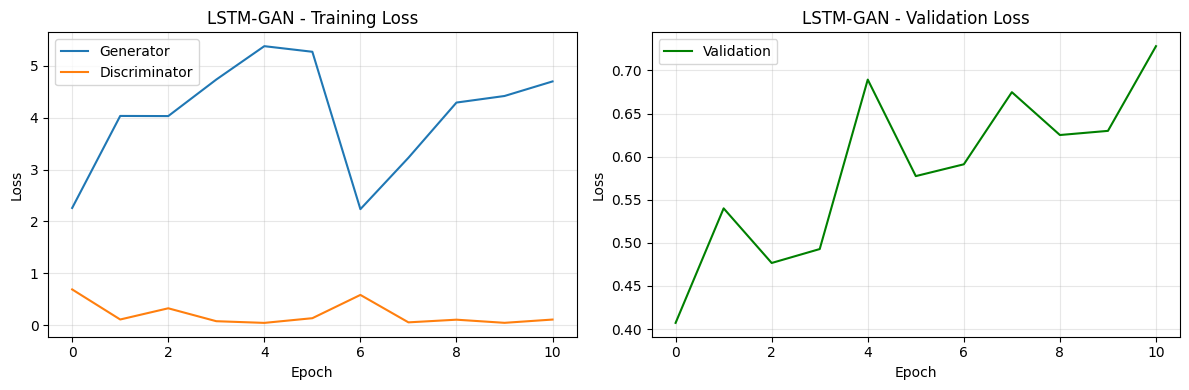

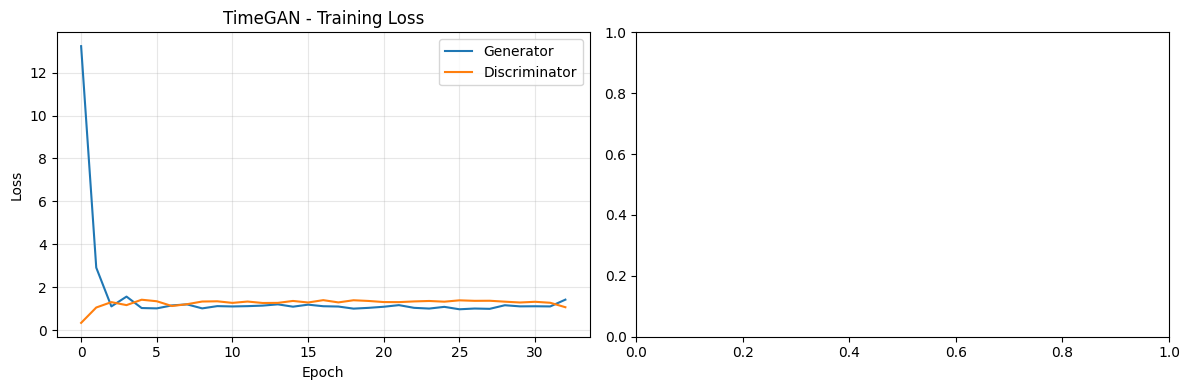

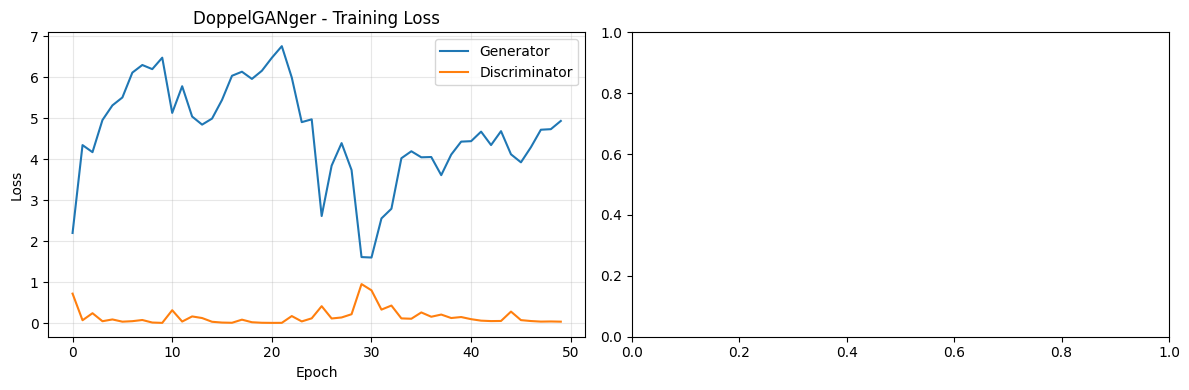

In [30]:
# Plot training history
for name, history in histories.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    if 'g_loss' in history:
        axes[0].plot(history['g_loss'], label='Generator')
    if 'd_loss' in history:
        axes[0].plot(history['d_loss'], label='Discriminator')
    axes[0].set_title(f'{name} - Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    if 'val_loss' in history:
        axes[1].plot(history['val_loss'], label='Validation', color='green')
        axes[1].set_title(f'{name} - Validation Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], f'{name}_training.png'), dpi=100)
    plt.show()

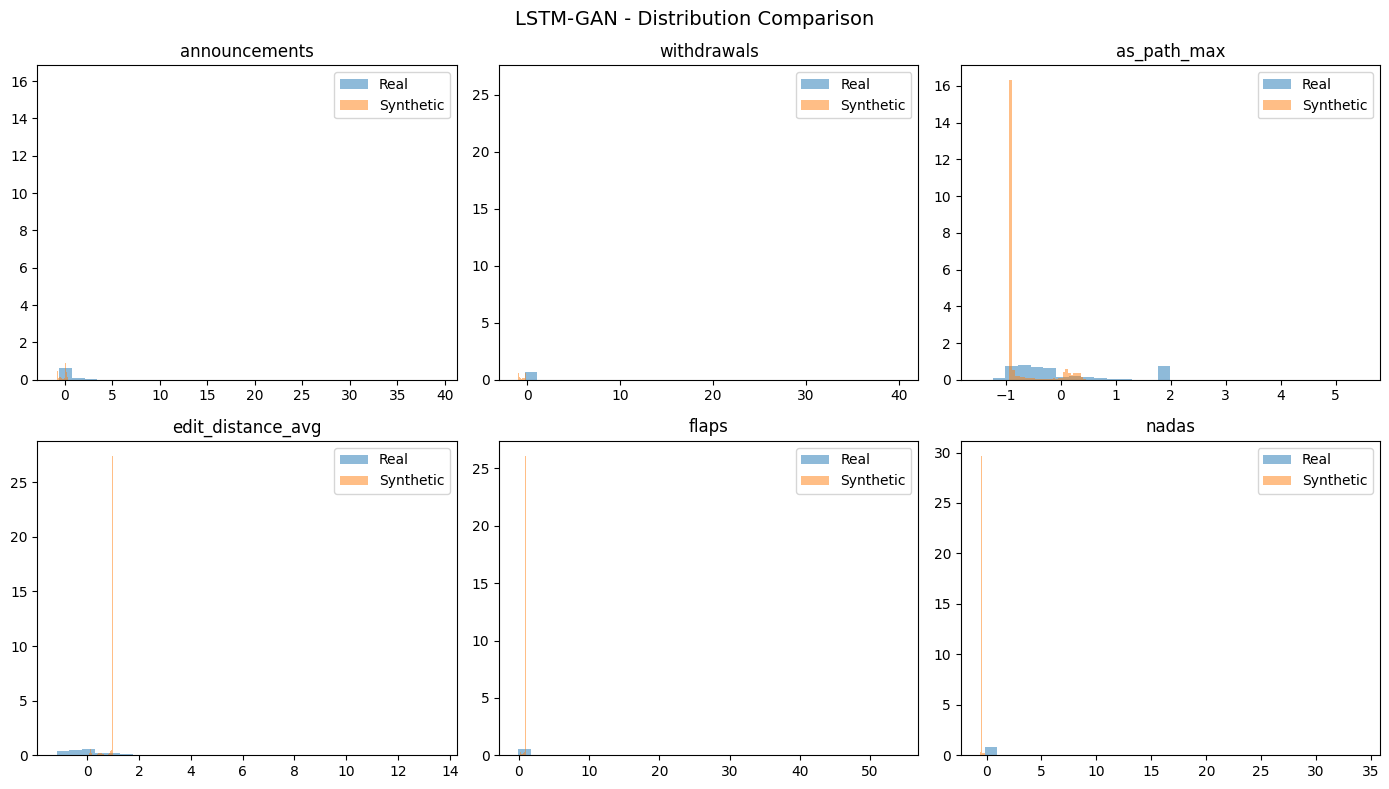

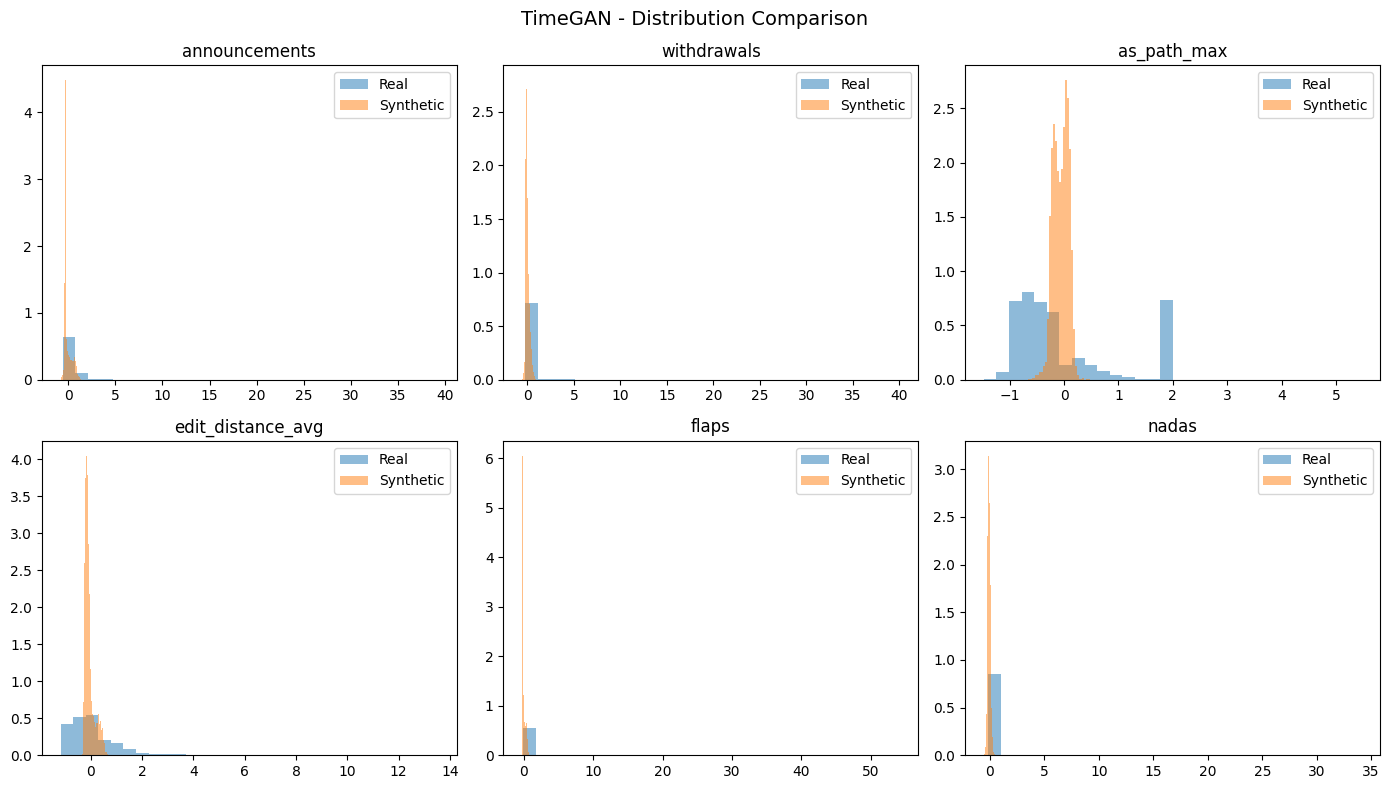

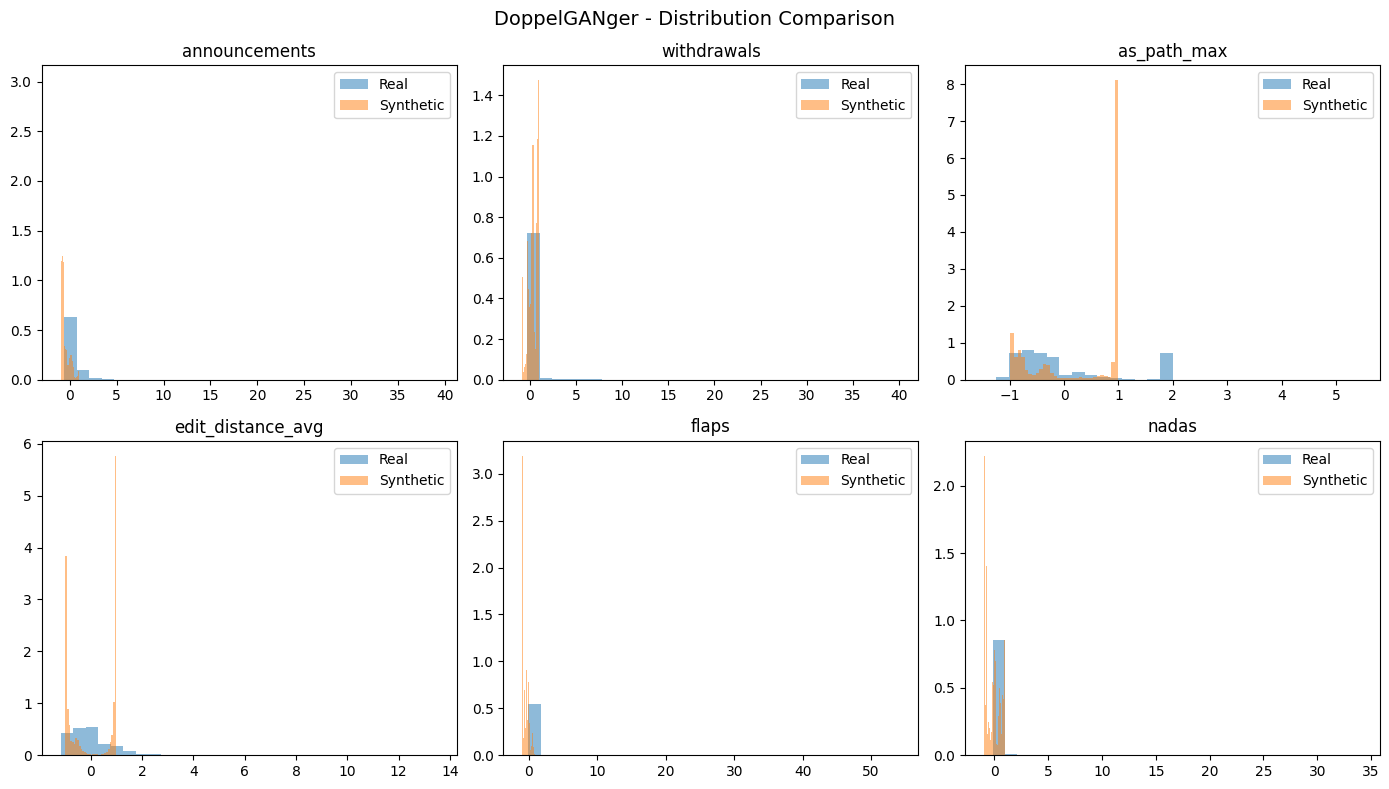

In [31]:
# Plot distribution comparison for key features
key_features = ['announcements', 'withdrawals', 'as_path_max', 'edit_distance_avg', 'flaps', 'nadas']
key_indices = [available_features.index(f) for f in key_features if f in available_features]

for name, syn_data in synthetic_data.items():
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    real_flat = X_test.reshape(-1, X_test.shape[-1])
    syn_flat = syn_data.reshape(-1, syn_data.shape[-1])
    
    for idx, feat_idx in enumerate(key_indices[:6]):
        axes[idx].hist(real_flat[:, feat_idx], bins=30, alpha=0.5, label='Real', density=True)
        axes[idx].hist(syn_flat[:, feat_idx], bins=30, alpha=0.5, label='Synthetic', density=True)
        axes[idx].set_title(available_features[feat_idx])
        axes[idx].legend()
    
    plt.suptitle(f'{name} - Distribution Comparison', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], f'{name}_distributions.png'), dpi=100)
    plt.show()

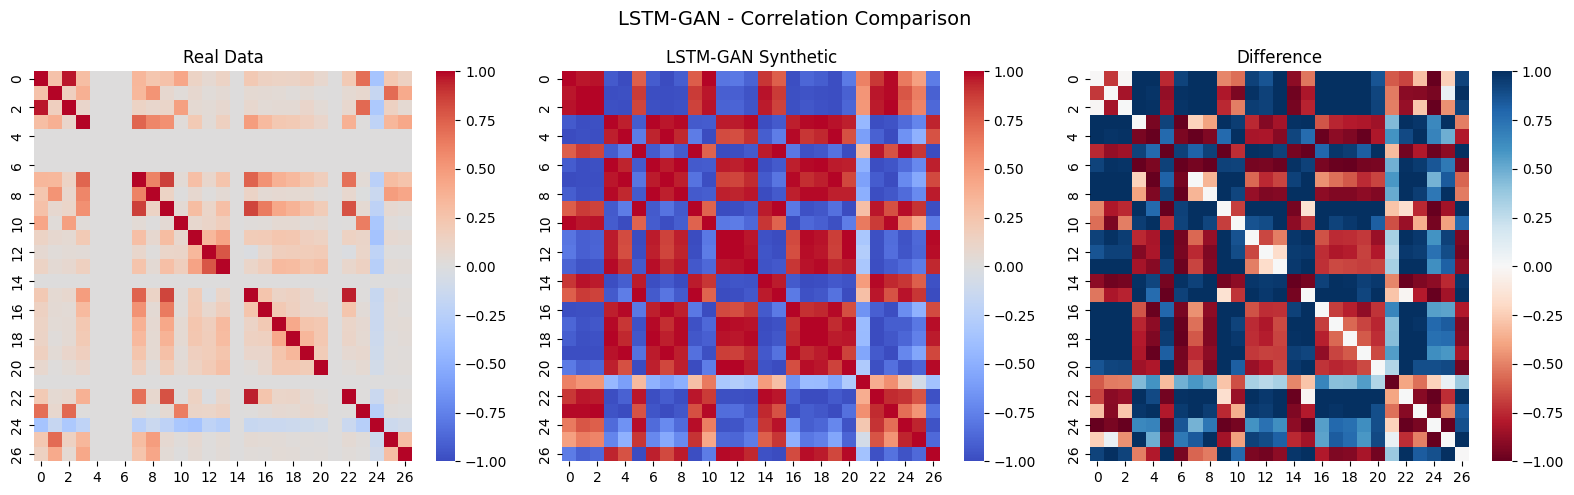

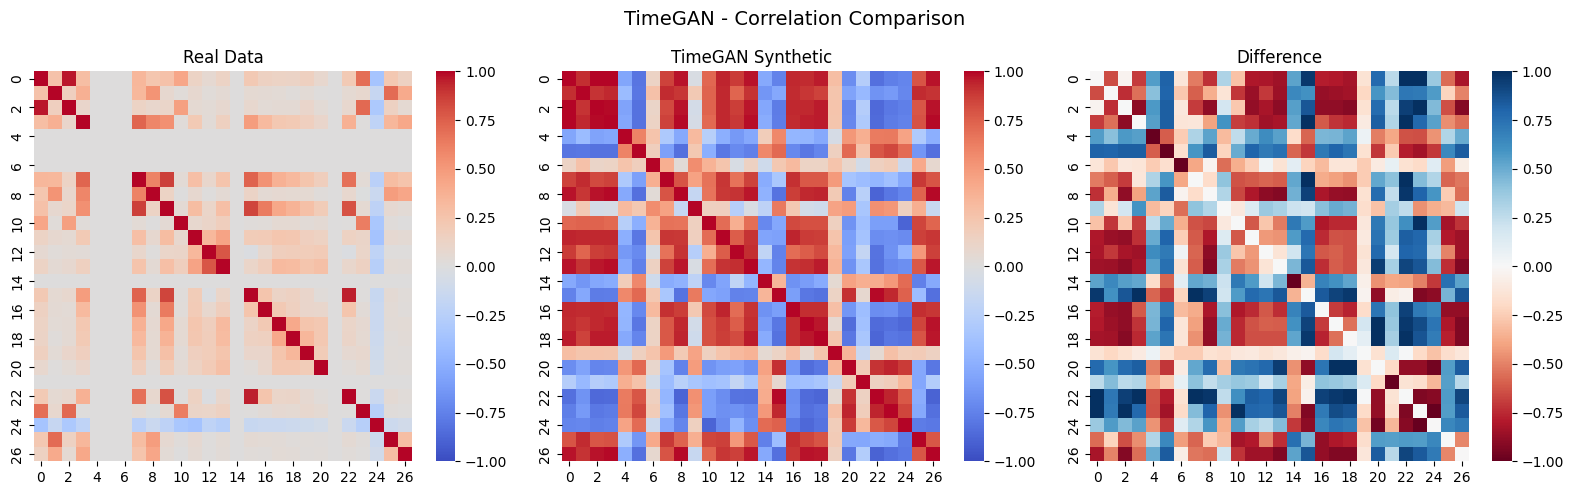

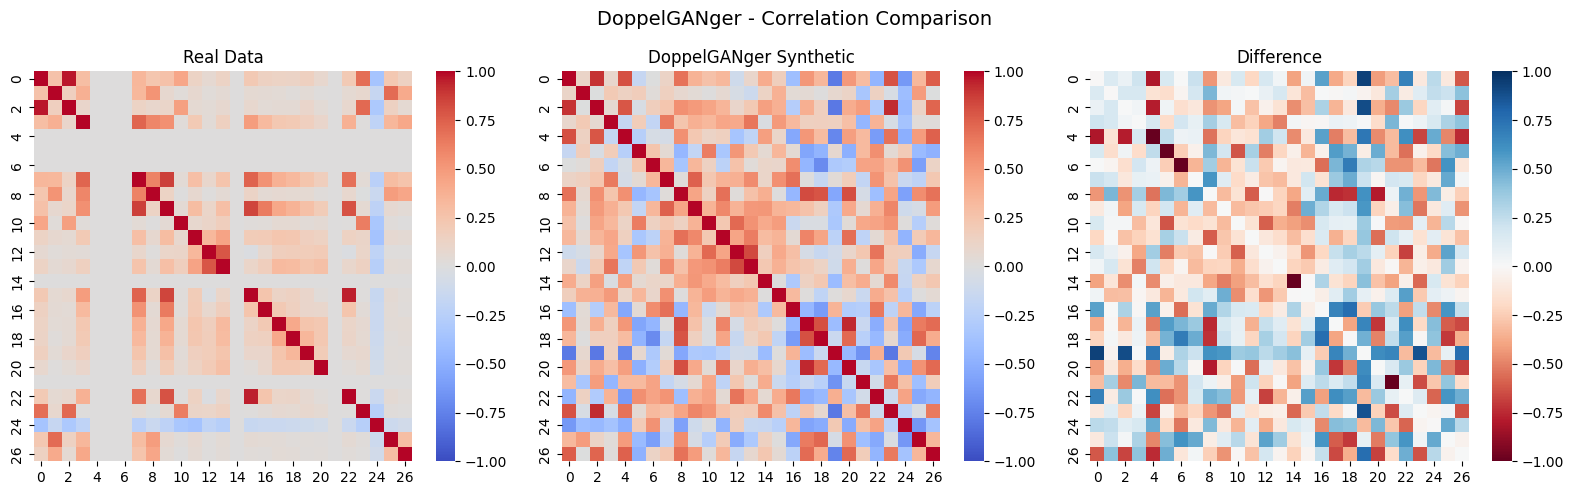

In [32]:
# Correlation heatmap comparison
for name, syn_data in synthetic_data.items():
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    real_flat = X_test.reshape(-1, X_test.shape[-1])
    syn_flat = syn_data.reshape(-1, syn_data.shape[-1])
    
    real_corr = np.nan_to_num(np.corrcoef(real_flat.T))
    syn_corr = np.nan_to_num(np.corrcoef(syn_flat.T))
    
    sns.heatmap(real_corr, ax=axes[0], cmap='coolwarm', center=0, vmin=-1, vmax=1)
    axes[0].set_title('Real Data')
    
    sns.heatmap(syn_corr, ax=axes[1], cmap='coolwarm', center=0, vmin=-1, vmax=1)
    axes[1].set_title(f'{name} Synthetic')
    
    sns.heatmap(real_corr - syn_corr, ax=axes[2], cmap='RdBu', center=0, vmin=-1, vmax=1)
    axes[2].set_title('Difference')
    
    plt.suptitle(f'{name} - Correlation Comparison', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], f'{name}_correlation.png'), dpi=100)
    plt.show()

## Part 7: Save Results

In [33]:
# Select best model (if multiple trained)
if len(all_metrics) > 1:
    best_model_name = min(all_metrics.keys(), key=lambda k: all_metrics[k]['overall_score'])
else:
    best_model_name = list(all_metrics.keys())[0]

print(f"\nBest model: {best_model_name}")
best_synthetic = synthetic_data[best_model_name]


Best model: TimeGAN


In [34]:
# Inverse transform to original scale
print("\nInverse transforming to original scale...")
best_synthetic_flat = best_synthetic.reshape(-1, num_features)
best_synthetic_original = scaler.inverse_transform(best_synthetic_flat)
best_synthetic_original = best_synthetic_original.reshape(best_synthetic.shape)

# Save to CSV
n_samples, seq_len_out, n_features = best_synthetic_original.shape
records = []

for i in range(n_samples):
    for t in range(seq_len_out):
        record = {'sequence_id': i, 'timestep': t, 'label': 'normal'}
        for j, feat in enumerate(available_features):
            record[feat] = best_synthetic_original[i, t, j]
        records.append(record)

synthetic_df = pd.DataFrame(records)
output_path = os.path.join(CONFIG['output_dir'], 'synthetic_normal_traffic.csv')
synthetic_df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")
print(f"Total records: {len(synthetic_df)}")


Inverse transforming to original scale...
Saved to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/synthetic_normal_traffic.csv
Total records: 10000


In [35]:
# Save model checkpoint
for name, model in trained_models.items():
    checkpoint_path = os.path.join(CONFIG['output_dir'], f'{name.lower().replace("-", "_")}_checkpoint.pt')
    
    if hasattr(model, 'generator'):
        torch.save({
            'generator': model.generator.state_dict() if hasattr(model.generator, 'state_dict') else None,
            'discriminator': model.discriminator.state_dict() if hasattr(model.discriminator, 'state_dict') else None,
        }, checkpoint_path)
    print(f"Saved {name} checkpoint to: {checkpoint_path}")

Saved LSTM-GAN checkpoint to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/lstm_gan_checkpoint.pt
Saved TimeGAN checkpoint to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/timegan_checkpoint.pt
Saved DoppelGANger checkpoint to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/doppelganger_checkpoint.pt


In [36]:
# Save scaler
import pickle
scaler_path = os.path.join(CONFIG['output_dir'], 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler to: {scaler_path}")

Saved scaler to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/scaler.pkl


In [37]:
# Save results summary
results = {
    'config': {k: str(v) if not isinstance(v, (int, float, bool, type(None))) else v 
               for k, v in CONFIG.items()},
    'best_model': best_model_name,
    'metrics': all_metrics,
    'data_info': {
        'original_samples': len(df),
        'normal_samples': len(df_normal),
        'num_features': num_features,
        'train_sequences': len(X_train),
        'test_sequences': len(X_test),
    },
    'timestamp': datetime.now().isoformat()
}

results_path = os.path.join(CONFIG['output_dir'], 'training_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)
print(f"Saved results to: {results_path}")

Saved results to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/training_results.json


## Part 8: Summary

In [38]:
print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)

print(f"""
Configuration:
  - Model trained: {CONFIG['model_to_train']}
  - Epochs: {CONFIG['epochs']}
  - Sequence length: {CONFIG['sequence_length']}
  - Hidden dim: {CONFIG['hidden_dim']}

Data:
  - Training sequences: {len(X_train)}
  - Test sequences: {len(X_test)}
  - Features: {num_features}

Results:
  - Best model: {best_model_name}
  - Overall score: {all_metrics[best_model_name]['overall_score']:.4f}

Output files saved to: {CONFIG['output_dir']}
  - synthetic_normal_traffic.csv
  - *_checkpoint.pt (model weights)
  - scaler.pkl
  - training_results.json
  - *.png (visualizations)
""")

# List output files
print("Generated files:")
for f in sorted(os.listdir(CONFIG['output_dir'])):
    size = os.path.getsize(os.path.join(CONFIG['output_dir'], f)) / 1024
    print(f"  {f}: {size:.1f} KB")


TRAINING COMPLETE - SUMMARY

Configuration:
  - Model trained: all
  - Epochs: 50
  - Sequence length: 20
  - Hidden dim: 64

Data:
  - Training sequences: 3600
  - Test sequences: 1000
  - Features: 27

Results:
  - Best model: TimeGAN
  - Overall score: 0.3804

Output files saved to: /home/smotaali/BGP_Traffic_Generation/results/gan_outputs_optimized/
  - synthetic_normal_traffic.csv
  - *_checkpoint.pt (model weights)
  - scaler.pkl
  - training_results.json
  - *.png (visualizations)

Generated files:
  DoppelGANger_correlation.png: 50.8 KB
  DoppelGANger_distributions.png: 53.5 KB
  DoppelGANger_training.png: 43.5 KB
  LSTM-GAN_correlation.png: 49.0 KB
  LSTM-GAN_distributions.png: 48.9 KB
  LSTM-GAN_training.png: 51.2 KB
  TimeGAN_correlation.png: 48.8 KB
  TimeGAN_distributions.png: 49.9 KB
  TimeGAN_training.png: 30.5 KB
  doppelganger_checkpoint.pt: 440.5 KB
  lstm_gan_checkpoint.pt: 448.7 KB
  scaler.pkl: 1.1 KB
  synthetic_normal_traffic.csv: 2976.2 KB
  timegan_checkpoint.